In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [5]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import skimage
import torch
import nibabel as nib

from totalsegmentator.python_api import totalsegmentator
from totalsegmentator.libs import combine_masks

import pygalmesh
import meshio

sys.path.append('..')
import project

torch.cuda.is_available()

True

In [6]:
%autoreload
emory4dct = project.imaging.Emory4DCT('../data/Emory-4DCT')
emory4dct

Emory4DCT('../data/Emory-4DCT', 10 cases)

In [7]:
def select_regions_by_size(mask, which=slice(1, 3)):
    regions = skimage.measure.label(mask)
    region_sizes = np.unique(regions, return_counts=True)[1]
    selected_regions = np.argsort(-region_sizes)[which]
    return np.isin(regions, selected_regions).astype(mask.dtype)

mask = np.array([
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
])
select_regions_by_size(mask)

array([[1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
%%time
for case in emory4dct.cases:
    for phase in emory4dct.phases:
        print(f'Segmenting {case.case_name} phase {phase}')
        
        image_file = case.nifti_file(phase=phase)
        mask_file = case.mask_file(phase=phase, roi='lung_combined_mask')
        mask_dir = mask_file.parent
        
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='total',
            roi_subset=[
                'lung_upper_lobe_right',
                'lung_middle_lobe_right',
                'lung_lower_lobe_right',
                'lung_upper_lobe_left',
                'lung_lower_lobe_left'
            ],
        )
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='lung_vessels'
        )
        totalsegmentator(
            input=image_file,
            output=mask_dir,
            task='body'
        )
        mask_nii = combine_masks(
            mask_dir=mask_dir,
            class_type='lung'
        )

        # select only the largest connected regions
        mask_data = mask_nii.get_fdata()
        new_mask_data = select_regions_by_size(mask_data)
        new_mask_nii = nib.nifti1.Nifti1Image(new_mask_data, mask_nii.affine)        
        
        nib.save(new_mask_nii, mask_file)

In [52]:
case = emory4dct[0]
case.load_niftis()
case.load_masks(roi=[
    'lung_lower_lobe_left',
    'lung_upper_lobe_left',
    
    'lung_lower_lobe_right',
    'lung_middle_lobe_right',
    'lung_upper_lobe_right',
    
    'lung_trachea_bronchia',
    'lung_vessels',
])

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_lower_lobe_left.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_upper_lobe_left.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_lower_lobe_right.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_middle_lobe_right.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSeg

regions


<IPython.core.display.Javascript object>


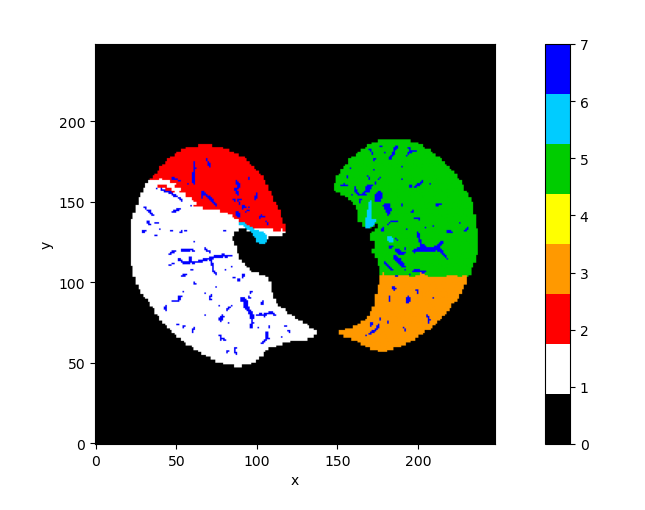

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [53]:
import xarray as xr
region_id = xr.DataArray(np.arange(7)+1, dims=['roi'], coords={'roi': case.mask.roi})
regions = (case.mask * region_id).max('roi')
#regions = (case.mask * region_id).sel(roi=['lung_trachea_bronchia', 'lung_vessels', 'lung_lower_lobe_left']).max('roi')
regions.name = 'regions'
project.visual.XArrayViewer(regions).update_index(phase=0, z=48)

In [55]:
%%time
mesh = pygalmesh.generate_from_array(
    regions.sel(phase=0).values.astype(np.uint16),
    voxel_size=case.resolution,
    max_cell_circumradius={
        'default': 10.0,
        6: 5.0, # airways
        7: 2.0, # vessels
    },
    min_facet_angle=15,
    max_facet_distance=1.0,
    odt=True,
    lloyd=True,
)
mesh = project.meshing.remove_unused_points(mesh)
mesh

CPU times: user 15.7 s, sys: 76.6 ms, total: 15.8 s
Wall time: 16.4 s


<meshio mesh object>
  Number of points: 17594
  Number of cells:
    triangle: 72446
    tetra: 89638

In [56]:
project.meshing.save_mesh_meshio('mesh.xdmf', mesh, cell_blocks=[1])
project.meshing.load_mesh_fenics('mesh.xdmf')

Loading mesh.xdmf... 17594


In [57]:
print('\n'*5)

In [58]:
%autoreload

In [60]:
%%time
for case in emory4dct.cases:
    case.load_niftis()
    case.load_masks(roi=[
        'lung_lower_lobe_left',
        'lung_upper_lobe_left',

        'lung_lower_lobe_right',
        'lung_upper_lobe_right',
        'lung_middle_lobe_right',

        'lung_trachea_bronchia',
        'lung_vessels',
    ])
    region_id = xr.DataArray(np.arange(7)+1, dims=['roi'], coords={'roi': case.mask.roi})
    case.mask = (case.mask * region_id).max('roi')
    case.save_masks(roi='lung_regions')
    
    for phase in emory4dct.phases:
        mask = case.mask.sel(phase=phase)
        mesh = pygalmesh.generate_from_array(
            mask.values.astype(np.uint16),
            voxel_size=case.resolution,
            max_cell_circumradius={
                'default': 10.0,
                6: 5.0, # airways
                7: 2.0, # vessels
            },
            min_facet_angle=15,
            max_facet_distance=1.0,
            odt=True,
            lloyd=True,
        )
        mesh = project.meshing.remove_unused_points(mesh)

        case.mesh_dir.mkdir(exist_ok=True)
        mesh_file = case.mesh_file(phase, roi='lung_regions', radius=10)
        
        project.meshing.save_mesh_meshio(mesh_file, mesh, cell_blocks=[1])
        mesh = project.meshing.load_mesh_fenics(mesh_file)         

mesh

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_lower_lobe_left.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_upper_lobe_left.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_lower_lobe_right.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_upper_lobe_right.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegm

Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T80_lung_regions_10.xdmf... 17308
Loading ../data/Emory-4DCT/Case1Pack/pygalmesh/case1_T90_lung_regions_10.xdmf... 17842
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T10.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T20.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T30.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T40.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T50.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T60.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T70.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T80.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T90.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T00/lung_lower_lobe_left.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T00/lung_upper_lobe_left.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/

Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T60_lung_regions_10.xdmf... 39875
Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T70_lung_regions_10.xdmf... 41489
Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T80_lung_regions_10.xdmf... 37849
Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T90_lung_regions_10.xdmf... 38349
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T00.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T10.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T20.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T30.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T40.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T50.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T60.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T70.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T80.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/NIFTI/case3_T90.nii.gz
Loading ../data/Emory-4DCT/Case3Pack/TotalSegment/ca

Loading ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T40_lung_regions_10.xdmf... 42404
Loading ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T50_lung_regions_10.xdmf... 43259
Loading ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T60_lung_regions_10.xdmf... 43993
Loading ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T70_lung_regions_10.xdmf... 43141
Loading ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T80_lung_regions_10.xdmf... 44282
Loading ../data/Emory-4DCT/Case3Pack/pygalmesh/case3_T90_lung_regions_10.xdmf... 43307
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T00.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T10.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T20.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T30.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T40.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T50.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T60.nii.gz
Loading ../data/Emory-4DCT/Case4Pack/NIFTI/case4_T70.nii.g

Loading ../data/Emory-4DCT/Case4Pack/pygalmesh/case4_T20_lung_regions_10.xdmf... 43401
Loading ../data/Emory-4DCT/Case4Pack/pygalmesh/case4_T30_lung_regions_10.xdmf... 43646
Loading ../data/Emory-4DCT/Case4Pack/pygalmesh/case4_T40_lung_regions_10.xdmf... 43447
Loading ../data/Emory-4DCT/Case4Pack/pygalmesh/case4_T50_lung_regions_10.xdmf... 43773
Loading ../data/Emory-4DCT/Case4Pack/pygalmesh/case4_T60_lung_regions_10.xdmf... 44201
Loading ../data/Emory-4DCT/Case4Pack/pygalmesh/case4_T70_lung_regions_10.xdmf... 42957
Loading ../data/Emory-4DCT/Case4Pack/pygalmesh/case4_T80_lung_regions_10.xdmf... 41637
Loading ../data/Emory-4DCT/Case4Pack/pygalmesh/case4_T90_lung_regions_10.xdmf... 43212
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T00.nii.gz
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T10.nii.gz
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T20.nii.gz
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T30.nii.gz
Loading ../data/Emory-4DCT/Case5Pack/NIFTI/case5_T40.nii.gz
Load

Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T00_lung_regions_10.xdmf... 27981
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T10_lung_regions_10.xdmf... 32861
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T20_lung_regions_10.xdmf... 31069
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T30_lung_regions_10.xdmf... 28847
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T40_lung_regions_10.xdmf... 29801
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T50_lung_regions_10.xdmf... 30314
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T60_lung_regions_10.xdmf... 33254
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T70_lung_regions_10.xdmf... 29654
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T80_lung_regions_10.xdmf... 31317
Loading ../data/Emory-4DCT/Case5Pack/pygalmesh/case5_T90_lung_regions_10.xdmf... 29312
Loading ../data/Emory-4DCT/Case6Pack/NIFTI/case6_T00.nii.gz
Loading ../data/Emory-4DCT/Case6Pack/NIFTI/case6_T10.nii.gz
Loading ..

Saving ../data/Emory-4DCT/Case6Pack/TotalSegment/case6_T80/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case6Pack/TotalSegment/case6_T90/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T00_lung_regions_10.xdmf... 45424
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T10_lung_regions_10.xdmf... 44005
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T20_lung_regions_10.xdmf... 45129
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T30_lung_regions_10.xdmf... 44228
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T40_lung_regions_10.xdmf... 45533
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T50_lung_regions_10.xdmf... 47498
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T60_lung_regions_10.xdmf... 46355
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T70_lung_regions_10.xdmf... 45189
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T80_lung_regions_10.xdmf... 46029
Loading ../data/Emory-4DCT/Case6Pack/pygalmesh/case6_T90_lu

Saving ../data/Emory-4DCT/Case7Pack/TotalSegment/case7_T60/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case7Pack/TotalSegment/case7_T70/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case7Pack/TotalSegment/case7_T80/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case7Pack/TotalSegment/case7_T90/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T00_lung_regions_10.xdmf... 37807
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T10_lung_regions_10.xdmf... 37953
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T20_lung_regions_10.xdmf... 37970
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T30_lung_regions_10.xdmf... 37011
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T40_lung_regions_10.xdmf... 38811
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T50_lung_regions_10.xdmf... 38380
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T60_lung_regions_10.xdmf... 37699
Loading ../data/Emory-4DCT/Case7Pack/pygalmesh/case7_T70_lung_regions_10.xd

Saving ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T20/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T30/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T40/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T50/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T60/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T70/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T80/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case8Deploy/TotalSegment/case8_T90/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T00_lung_regions_10.xdmf... 40168
Loading ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T10_lung_regions_10.xdmf... 39747
Loading ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T20_lung_regions_10.xdmf... 45633
Loading ../data/Emory-4DCT/Case8Deploy/pygalmesh/case8_T30_lung_regions_10.xdmf... 42

Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T00/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T10/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T20/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T30/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T40/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T50/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T60/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T70/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T80/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case9Pack/TotalSegment/case9_T90/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case9Pack/pygalmesh/case9_T00_lung_regions_10.xdmf... 25758
Loading ../data/Emory-4DCT/Case9Pack/pygalmesh/case9_T10_lung_regions_10.xdmf... 28551
Loading ../data/Emory-4DCT/Case9Pack

Loading ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T90/lung_vessels.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T00/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T10/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T20/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T30/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T40/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T50/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T60/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T70/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T80/lung_regions.nii.gz
Saving ../data/Emory-4DCT/Case10Pack/TotalSegment/case10_T90/lung_regions.nii.gz
Loading ../data/Emory-4DCT/Case10Pack/pygalmesh/case10_T00_lung_regions_10.xdmf... 32663
Loading ../data/Emo